Case 2 - Pneumonia
==================
Henrik Hokkanen, Simo Mäkelä  
1.3.2020  
Neural Networks for Health Technology Applications  
Helsinki Metropolia University of Applied Sciences

Introduction
------------

In this exercise, the aim is to create three binary classifiers for x-ray chest images to detect pneumonia, and compare their performance. The classifiers created are convolutional neural networks (CNN). The dataset in use can be found at https://data.mendeley.com/datasets/rscbjbr9sj/2

In [8]:
import time
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.models import load_model
from tensorflow.keras.metrics import SensitivityAtSpecificity, Accuracy, FalseNegatives, FalsePositives
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import pandas as pd

In [9]:
device_name = tf.test.gpu_device_name()
if "GPU" not in device_name:
    print("GPU device not found")
print("Found GPU at: {}".format(device_name))

GPU device not found
Found GPU at: 


## Data Source

In [10]:
#train_dir = r'/kaggle/input/chest-xray-images-for-classification-pneumonia/pneumonia2/train'
#val_dir = r'/kaggle/input/chest-xray-images-for-classification-pneumonia/pneumonia2/validation'
#test_dir = r'/kaggle/input/chest-xray-images-for-classification-pneumonia/pneumonia2/test'

In [11]:
train_dir = r'C:\Temp\Case2_XRay\train'
val_dir = r'C:\Temp\Case2_XRay\validation'
test_dir = r'C:\Temp\Case2_XRay\test'

## Generators and Image Data Augmentation

We augment the training dataset by slight rotation (-5...+5 degrees) and a possibility of a horizontal flip. We don't want to do any wild rotation or random cropping, as the thoracic AP or PA x-ray projection can be expected to be fairly constant in orientation and proportions.

If we were to e.g. flip the images vertically, then the algorithm might learn to mistakenly find signs of pneumonia in areas where there is no lung tissue.

Batch size was selected by running a few tests using batch sizes 8, 16 and 32. No significant penalty in computation time was noticed, but batch size 8 seemed to produce slightly better loss function minimization. Batch size selection notebook can be found at https://www.kaggle.com/simomake/case-2-batch-size-selection

In [13]:
batch_size = 8

train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range = 5, 
                                   horizontal_flip = True)

val_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (150, 150),
    batch_size = batch_size,
    class_mode = 'binary')

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size = (150, 150),
    batch_size = batch_size,
    shuffle = False,
    class_mode='binary')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = (150, 150),
    batch_size = 1,
    shuffle = False,
    class_mode='binary')

Found 3513 images belonging to 2 classes.
Found 1172 images belonging to 2 classes.
Found 1171 images belonging to 2 classes.


__Metrics for the learning curves:__

In [12]:
metrics = [FalseNegatives(), FalsePositives(), SensitivityAtSpecificity(0.9)]

## Model Creation Functions
Three different models are created. The first one is the one given as an example in class, the other two are slight modifications of it.

In [14]:
def create_model_1():
    model = tf.keras.models.Sequential()
    model.add(Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(32, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(32, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(32, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(tf.keras.layers.Flatten())
    model.add(Dense(512, activation = 'relu'))
    model.add(Dense(1, activation = 'sigmoid'))

    model.compile(loss = 'binary_crossentropy',
                  optimizer = tf.keras.optimizers.RMSprop(lr = 1e-4),
                  metrics = metrics)

    return model

In [15]:
def create_model_2():
    model = tf.keras.models.Sequential()
    model.add(Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(32, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(tf.keras.layers.Flatten())
    model.add(Dense(512, activation = 'relu'))
    model.add(Dense(1, activation = 'sigmoid'))

    model.compile(loss = 'binary_crossentropy',
                  optimizer = 'adam',
                  metrics = metrics)

    return model

In [16]:
def create_model_3():
    model = tf.keras.models.Sequential()
    model.add(Conv2D(64, (3, 3), activation = 'relu', input_shape = (150, 150, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(tf.keras.layers.Flatten())
    model.add(Dense(512, activation = 'relu'))
    model.add(Dense(1, activation = 'sigmoid'))

    model.compile(loss = 'binary_crossentropy',
                  optimizer = tf.keras.optimizers.RMSprop(lr = 0.00001),
                  metrics = metrics)

    return model

## Model Training Function
This function is used to fit the models.

In [17]:
def train_model(model, epochs, logger):
    t_start = time.time()

    hist = model.fit_generator(
        train_generator,
        steps_per_epoch = None,
        verbose = 1,
        epochs = epochs,
        validation_data = val_generator,
        validation_steps = None,
        callbacks = [logger]
    )

    t_end = time.time()
    t_elapsed = t_end - t_start

    print('Time elapsed = %0f' % t_elapsed)

    model.save('case2_' + time.strftime("%Y%m%d-%H%M%S") + '.h5')
    
    return hist

__The following function prints learning curves from training history metrics.__

In [18]:
def show_learning_curves(hist):
    sens = [val for key, val in hist.history.items() if key.startswith('sensitivity_at_specificity')][0]
    val_sens = [val for key, val in hist.history.items() if key.startswith('val_sensitivity_at_specificity')][0]
    fp = [val for key, val in hist.history.items() if key.startswith('false_positives')][0]
    val_fp = [val for key, val in hist.history.items() if key.startswith('val_false_positives')][0]
    fn = [val for key, val in hist.history.items() if key.startswith('false_negatives')][0]
    val_fn = [val for key, val in hist.history.items() if key.startswith('val_false_negatives')][0]
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']
    epochs = range(len(sens))

    plt.figure(figsize=(14,9))
    plt.subplot(2, 2, 1)
    plt.plot(epochs, sens, 'bo-', label='Training sens')
    plt.plot(epochs, val_sens, 'r*-', label='Validation sens')
    plt.title('Sensitivity at specificity 0.9')
    plt.grid()
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training loss')
    plt.plot(epochs, val_loss, 'r*-', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.grid()

    plt.subplot(2, 2, 3)
    plt.plot(epochs, fp, 'bo-', label='False positives, training')
    plt.plot(epochs, val_fp, 'r*-', label='False positives, validation')
    plt.title('Training and validation FP')
    plt.legend()
    plt.grid()

    plt.subplot(2, 2, 4)
    plt.plot(epochs, fn, 'bo-', label='False negatives, training')
    plt.plot(epochs, val_fn, 'r*-', label='False negatives, validation')
    plt.title('Training and validation FN')
    plt.legend()
    plt.grid()

    plt.show()

## Metrics and Statistics
The following functions print out metrics, statistics, confusion matrices, ROC curves and sensitivity/specificity curves for threshold analysis.

In [40]:
def predict(model, generator):
    labels = generator.labels
    predicted = model.predict_generator(generator).flatten()
    return labels, predicted

def show_metrics(labels, predicted, threshold):
    plt.plot(predicted, label='predicted')
    plt.plot(labels, label='True value')
    plt.legend()
    plt.xlabel('Case index')
    plt.grid()

    cm = confusion_matrix(labels, predicted > threshold)
    print(cm)

    cr = classification_report(labels, predicted > threshold, target_names = ['normal (0)', 'pneumonia (1)'])
    print(cr)

In [20]:
def show_roc(labels, predicted):
    # ROC curve
    fpr, tpr, threshold =  roc_curve(labels, predicted, pos_label=1)

    roc_auc = auc(fpr, tpr)

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', color='green', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.grid()
    plt.show()

In [21]:
def show_threshold_analysis(labels, predicted):
    fpr, tpr, threshold =  roc_curve(labels, predicted, pos_label=1)
    # Threshold analysis
    plt.plot(threshold, 1-fpr, label = 'Specificity')
    plt.plot(threshold, tpr, label = 'Sensitivity')
    plt.axvline(0.5, color='red', linestyle=':')
    plt.xlim([0,1])
    plt.title('Threshold Value for Prediction')
    plt.xlabel('Threshold')
    plt.ylabel('Metrics Value')
    plt.legend()
    plt.grid()

## Model Creation and Training
We train the models once, as that is computationally expensive. The training history/metrics are stored for later use using `CSVLogger`. The trained models are saved in HDF5 format (`.h5`)

In [22]:
#model_1 = create_model_1()
#logger_1 = CSVLogger('training1.log', separator=',', append=False)
#hist_1 = train_model(model_1, epochs=10, logger=logger_1)

#model_2 = create_model_2()
#logger_2 = CSVLogger('training2.log', separator=',', append=False)
#hist_2 = train_model(model_2, epochs=15, logger=logger_2)

#model_3 = create_model_3()
#logger_3 = CSVLogger('training3.log', separator=',', append=False)
#hist_3 = train_model(model_3, epochs=10, logger=logger_3)

The training step above is commented out, as we now load the data from the files generated by the training step instead of rerunning it.

In [24]:
model_1 = load_model('case2_20200301-183850.h5')
model_2 = load_model('case2_20200301-185619.h5')
model_3 = load_model('case2_20200301-190808.h5')

class History:
    def __init__(self, history):
        self.history = history

h1 = pd.read_csv('training1.log', sep=',', engine='python')
hist_1 = History(h1)
h2 = pd.read_csv('training2.log', sep=',', engine='python')
hist_2 = History(h2)
h3 = pd.read_csv('training3.log', sep=',', engine='python')
hist_3 = History(h3)

## Learning Curves - Model 1

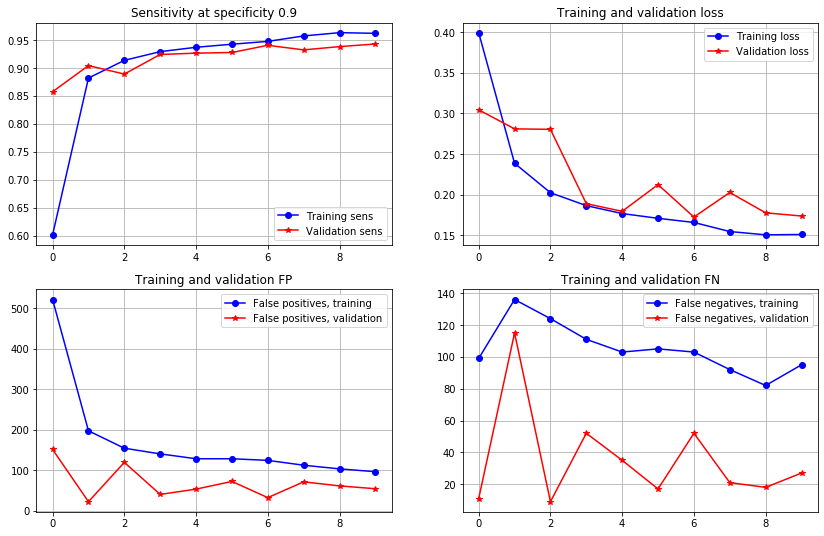

In [25]:
show_learning_curves(hist_1)

## Learning Curves - Model 2

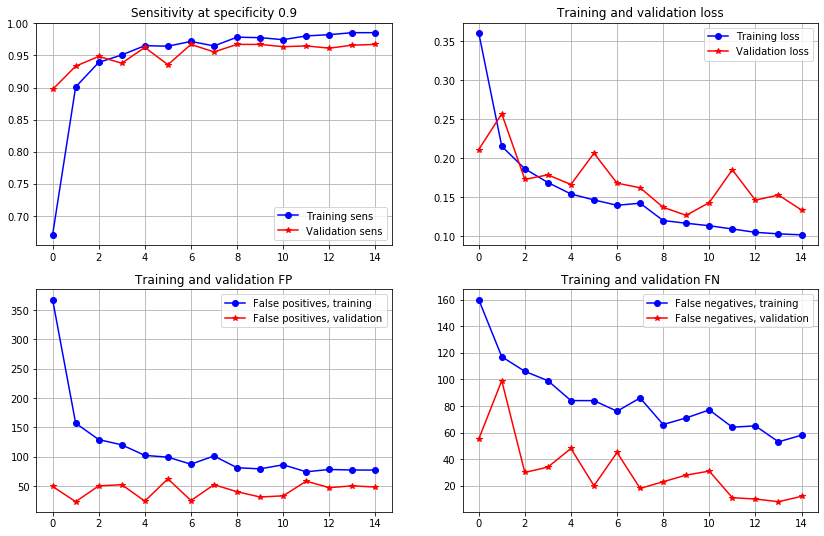

In [26]:
show_learning_curves(hist_2)

## Learning Curves - Model 3

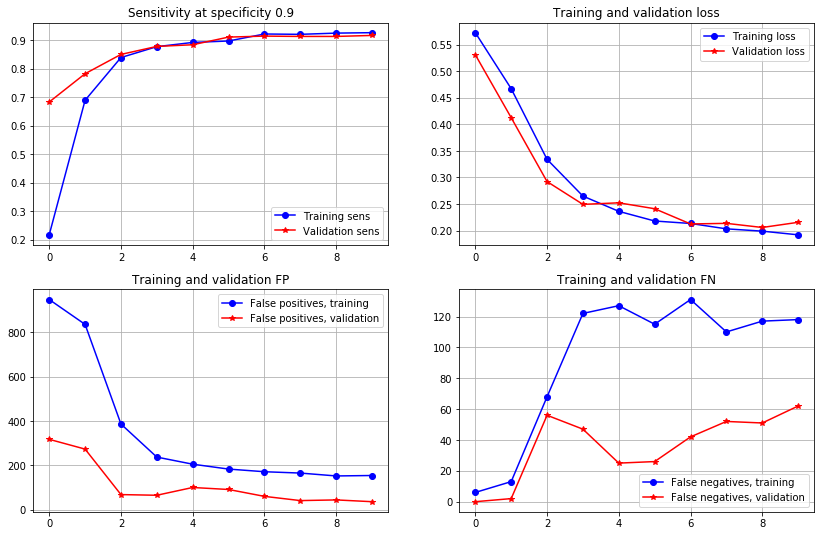

In [27]:
show_learning_curves(hist_3)

All three models show __acceptable learning curve behavior__. There are no signs of serious overfitting or instability.

In [ ]:
#labels_1, predicted_1 = predict(model_1, test_generator)
#labels_2, predicted_2 = predict(model_2, test_generator)
#labels_3, predicted_3 = predict(model_3, test_generator)

## Metrics
Let's look at some metrics from test set predictions.

The confusion matrices contain the following information:

            | PRED. HEALTHY        PRED. SICK
    --------+---------------------------------------         
    HEALTHY | true negative        false positive
    SICK    | false negative       true positive

In the classification reports,
- recall of the positive class is _sensitivity_
- recall of the negative class is _specificity_

$accuracy = \frac{correct\;predictions}{total\;samples}$ the ability of the test to make the correct classification  
$precision = \frac{true\;positives}{total\;positive}$ & $\frac{true\;negatives}{total\;negative}$ the ability of the test to make the correct positive or negative classification  
$sensitivity = \frac{true\;positives}{total\;sick}$: the ability of the test to detect disease  
$specificity = \frac{true\;negatives}{total\;healthy}$: the ability of the test to detect absence of disease

In very imbalanced classification problems, _accuracy_ is not the ideal metric. In our data set, about 70 % of the samples are positive. Bearing this in mind, an accuracy of 70 % is very bad, as it could be achieved by simply classifying every patient as sick.

The importance of the statistics _recall_ and _precision_ depends on how the model is going to be used. If it is very important to detect every single disease case, we value recall/sensitivity. Often we wish to have a balance between recall and precision to avoid unnecessary medical intervention, which could be costly or risky. This can be done by maximizing the _F1 score_, which is a harmonic mean of precision and recall.

## Metrics - Model 1

[[281  36]
 [ 21 833]]
               precision    recall  f1-score   support

   normal (0)       0.93      0.89      0.91       317
pneumonia (1)       0.96      0.98      0.97       854

     accuracy                           0.95      1171
    macro avg       0.94      0.93      0.94      1171
 weighted avg       0.95      0.95      0.95      1171



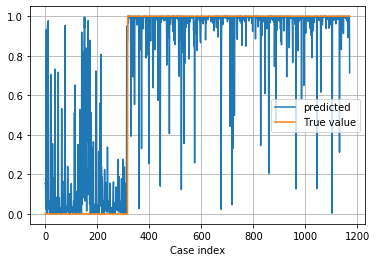

In [41]:
show_metrics(labels_1, predicted_1, threshold=0.5)

The first model is the teacher's example to act as a baseline. It seems to be quite sensitive, at cost of specificity, which means it is a bit more eager to produce positive results. Its overall accuracy is very good at 95 %.

## Metrics - Model 2

[[283  34]
 [ 11 843]]
               precision    recall  f1-score   support

   normal (0)       0.96      0.89      0.93       317
pneumonia (1)       0.96      0.99      0.97       854

     accuracy                           0.96      1171
    macro avg       0.96      0.94      0.95      1171
 weighted avg       0.96      0.96      0.96      1171



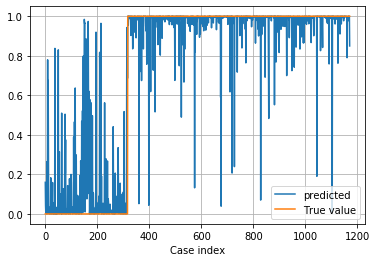

In [42]:
show_metrics(labels_2, predicted_2, threshold=0.5)

The second model was trained a bit longer. It tops the first model in overall accuracy. It, too is a bit on the sensitive side. Its negative class precision is better, which tells that there are less false negatives.

## Metrics - Model 3

[[290  27]
 [ 62 792]]
               precision    recall  f1-score   support

   normal (0)       0.82      0.91      0.87       317
pneumonia (1)       0.97      0.93      0.95       854

     accuracy                           0.92      1171
    macro avg       0.90      0.92      0.91      1171
 weighted avg       0.93      0.92      0.93      1171



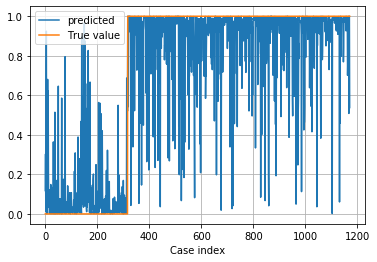

In [43]:
show_metrics(labels_3, predicted_3, threshold=0.5)

The third model has worse overall accuracy at 92 %. It produces significantly more false negatives, reducing its negative class precision to 82 %.

## ROC
The ROC curves support the above analysis.

## ROC - Model 1

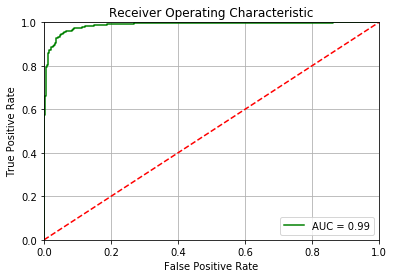

In [31]:
show_roc(labels_1, predicted_1)

## ROC - Model 2

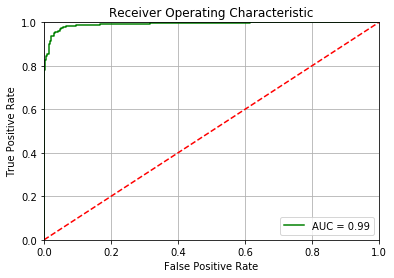

In [32]:
show_roc(labels_2, predicted_2)

## ROC - Model 3

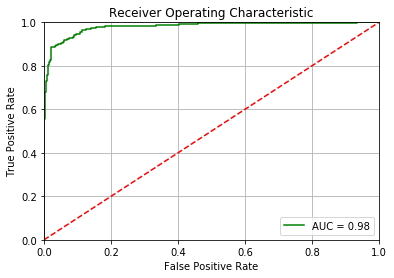

In [33]:
show_roc(labels_3, predicted_3)

## Threshold Analysis - Model 1

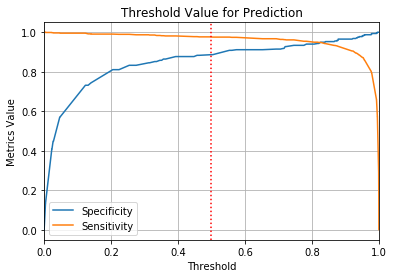

In [34]:
show_threshold_analysis(labels_1, predicted_1)

As mentioned earlier, model 1 is a bit on the sensitive side. To balance out, the discrimination threshold could be adjusted to 0.8 instead of 0.5.

## Threshold Analysis - Model 2

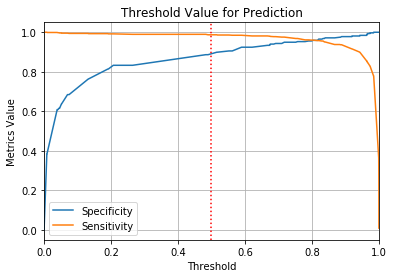

In [35]:
show_threshold_analysis(labels_2, predicted_2)

The same as above applies to model 2.

## Threshold Analysis - Model 3

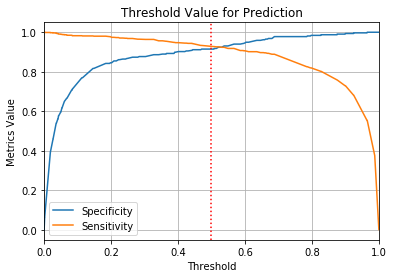

In [36]:
show_threshold_analysis(labels_3, predicted_3)

Model 3 seems to have its optimal discrimination threshold at 0.5.

## Threshold Correction
Let's see how model 2 behaves, if we set discrimination threshold to 0.8 compared to 0.5:

[[283  34]
 [ 11 843]]
               precision    recall  f1-score   support

   normal (0)       0.96      0.89      0.93       317
pneumonia (1)       0.96      0.99      0.97       854

     accuracy                           0.96      1171
    macro avg       0.96      0.94      0.95      1171
 weighted avg       0.96      0.96      0.96      1171



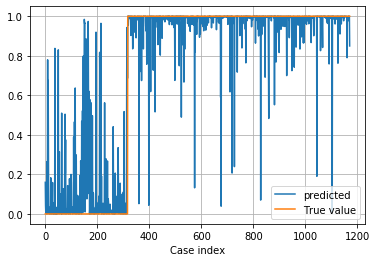

In [46]:
show_metrics(labels_2, predicted_2, threshold=0.5)

[[304  13]
 [ 34 820]]
               precision    recall  f1-score   support

   normal (0)       0.90      0.96      0.93       317
pneumonia (1)       0.98      0.96      0.97       854

     accuracy                           0.96      1171
    macro avg       0.94      0.96      0.95      1171
 weighted avg       0.96      0.96      0.96      1171



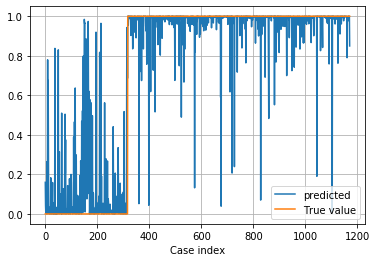

In [47]:
show_metrics(labels_2, predicted_2, threshold=0.8)

Sensitivity and specificity evened out, but any improvement in recall happened at cost of precision. In this case, increasing specificity worsened negative class precision, increasing false negatives.